In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math
import configparser
from sqlalchemy import create_engine  
import statsmodels.api as sm

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,FunctionTransformer,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error,mean_absolute_error

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso,Ridge

#Модели регрессии

#Gradient Boosting Regression
from sklearn.ensemble import GradientBoostingRegressor
#Elastic Net Regression
from sklearn.linear_model import ElasticNet
#Stochastic Gradient Descent Regression
from sklearn.linear_model import SGDRegressor
#Support Vector Machine
from sklearn.svm import SVR
#Bayesian Ridge Regression
from sklearn.linear_model import BayesianRidge
#CatBoost Regressor
from catboost import CatBoostRegressor
#Kernel Ridge Regression
from sklearn.kernel_ridge import KernelRidge
#Linear Regression
from sklearn.linear_model import LinearRegression
#Ridge and Lasso regression
#XGBoost Regressor
from xgboost import XGBRegressor
#LGBM Regressor
#from lightgbm import LGBMRegressor

# Подбор гиперпараметров



import pickle
%matplotlib inline



In [5]:
#Ставим кол-во выводимых строк и столбцов 

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

#Отключаем предупреждения

warnings.filterwarnings('ignore')

### Data Loading and Cleaning

In [27]:

#Используем если надо загрузить из локального csv файла
'''
train_data = 'train.csv'
test_data = 'test.csv'

with open(train_data) as train:
    train_df = pd.read_csv(train)
    
with open(test_data) as test:
    test_df = pd.read_csv(test)
'''
#Используем если данные лежат в postgres БД

config = configparser.ConfigParser()
config.read('config.ini')
conn_string = config.get('DATABASE', 'connection_url')

# Создаем строку подключения

engine = create_engine(conn_string)
table = 'house_prices_train'

# Выполняем SQL-запрос и загружаем данные в DataFrame
query = f"SELECT * FROM {table}"

train_df = pd.read_sql(query, engine)

# Печатаем первые строки для проверки
train_df.head(5)


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave  None      Reg   
1   2          20       RL         80.0     9600   Pave  None      Reg   
2   3          60       RL         68.0    11250   Pave  None      IR1   
3   4          70       RL         60.0     9550   Pave  None      IR1   
4   5          60       RL         84.0    14260   Pave  None      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0        None   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [28]:
train_df.shape

(1460, 82)

In [29]:
#Создаем копию нашего датасета на всякий случай

train_df_copy = train_df.copy(deep=True)

In [30]:
train_df_copy.shape

(1460, 82)

In [31]:
#Проверка на дубли

#train_df_copy.duplicated().sum()

train_df_copy[train_df_copy.duplicated()]


Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, dt]
Index: []

In [32]:
#Удаляем дубли

train_df_copy.drop_duplicates(inplace = True)

In [33]:
#Описание данных 

train_df_copy.describe().loc[['min', 'max', 'mean', 'std']].round(2)

Id  MSSubClass  LotFrontage    LotArea  OverallQual  OverallCond  \
min      1.00        20.0        21.00    1300.00         1.00         1.00   
max   1460.00       190.0       313.00  215245.00        10.00         9.00   
mean   730.50        56.9        70.05   10516.83         6.10         5.58   
std    421.61        42.3        24.28    9981.26         1.38         1.11   

      YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
min     1872.00       1950.00        0.00        0.00        0.00       0.00   
max     2010.00       2010.00     1600.00     5644.00     1474.00    2336.00   
mean    1971.27       1984.87      103.69      443.64       46.55     567.24   
std       30.20         20.65      181.07      456.10      161.32     441.87   

      TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
min          0.00    334.00      0.00          0.00     334.00          0.00   
max       6110.00   4692.00   2065.00        572.00    5642.00          3.00   
mean      1057.43   1162.63    346.99          5.84    1515.46          0.43   
std        438.71    386.59    436.53         48.62     525.48          0.52   

      BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
min           0.00      0.00      0.00          0.00          0.00   
max           2.00      3.00      2.00          8.00          3.00   
mean          0.06      1.57      0.38          2.87          1.05   
std           0.24      0.55      0.50          0.82          0.22   

      TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  GarageArea  \
min           2.00        0.00      1900.00        0.00        0.00   
max          14.00        3.00      2010.00        4.00     1418.00   
mean          6.52        0.61      1978.51        1.77      472.98   
std           1.63        0.64        24.69        0.75      213.80   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
min         0.00         0.00           0.00       0.00         0.00   
max       857.00       547.00         552.00     508.00       480.00   
mean       94.24        46.66          21.95       3.41        15.06   
std       125.34        66.26          61.12      29.32        55.76   

      PoolArea   MiscVal  MoSold   YrSold  SalePrice  
min       0.00      0.00    1.00  2006.00    34900.0  
max     738.00  15500.00   12.00  2010.00   755000.0  
mean      2.76     43.49    6.32  2007.82   180921.2  
std      40.18    496.12    2.70     1.33    79442.5

In [34]:
#Функции для создания таблицы по пропускам и визуализации фичей с пропусками

'''
data_frame - Датафрейм который передаем в функцию на проверку
missings_percent - % пустых значений который хотим проверить например missings_percent>0 покажет все колонки где есть пропуски

'''
def missings(data_frame,missings_percent):

    total = data_frame.isnull().sum().sort_values(ascending=False)
    percent = (data_frame.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data[(missing_data['Percent']>missings_percent)]
    
    return missing_data
    
def missings_bar_vizualisation(data_frame,missings_percent):
    
    try:

        total = data_frame.isnull().sum().sort_values(ascending=False)
        percent = (data_frame.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending=False)
        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        missing_data = missing_data[(missing_data['Percent']>missings_percent)]
    
        #plt.rcParams["figure.figsize"] = (10,5)
        sns.barplot(x=missing_data.index,y=missing_data['Percent'],data = missing_data)
        plt.xticks(rotation=70)
        plt.show()
    
    except ValueError:
        
        print('No missings')

In [35]:
missings(train_df_copy,0)

Total    Percent
PoolQC         1453  99.520548
MiscFeature    1406  96.301370
Alley          1369  93.767123
Fence          1179  80.753425
MasVnrType      872  59.726027
FireplaceQu     690  47.260274
LotFrontage     259  17.739726
GarageType       81   5.547945
GarageYrBlt      81   5.547945
GarageCond       81   5.547945
GarageFinish     81   5.547945
GarageQual       81   5.547945
BsmtFinType2     38   2.602740
BsmtExposure     38   2.602740
BsmtQual         37   2.534247
BsmtCond         37   2.534247
BsmtFinType1     37   2.534247
MasVnrArea        8   0.547945
Electrical        1   0.068493

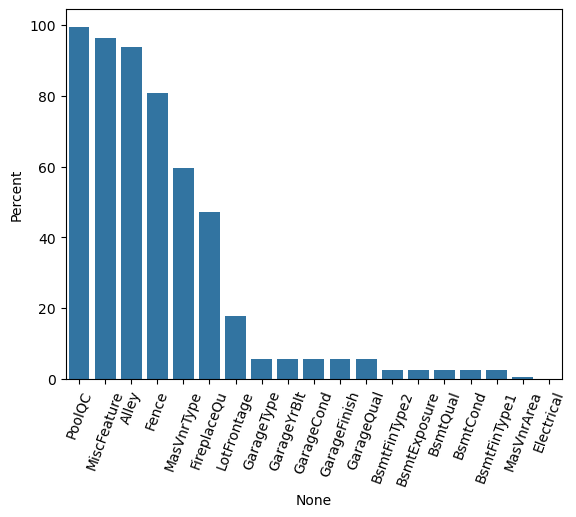

In [36]:
missings_bar_vizualisation(train_df_copy,0)

In [37]:
#Дропним у кого больше percent пропусков

percent = 60

#Записываем таблицу с % пропусков

missings_table = missings(train_df_copy,percent)

#Получаем список колонок на удаление

for_drop = missings_table.index.to_list()

#Удаляем колонки
after_drops = train_df_copy.drop(columns = for_drop)


In [38]:
for_drop

['PoolQC', 'MiscFeature', 'Alley', 'Fence']

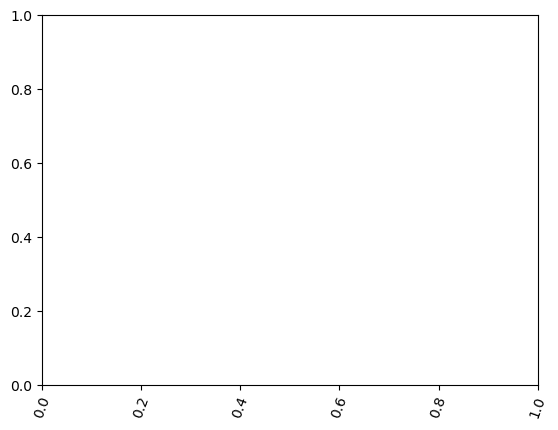

In [41]:
#Проверяем что удалились колонки с процентом пропусков больше чем percent

percent = 60
missings_bar_vizualisation(after_drops,percent)

In [42]:
after_drops.shape

(1460, 78)

In [44]:
#Смотрим на оставшуюся таблицу

after_drops.head(5)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0   1          60       RL         65.0     8450   Pave      Reg         Lvl   
1   2          20       RL         80.0     9600   Pave      Reg         Lvl   
2   3          60       RL         68.0    11250   Pave      IR1         Lvl   
3   4          70       RL         60.0     9550   Pave      IR1         Lvl   
4   5          60       RL         84.0    14260   Pave      IR1         Lvl   

  Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
0    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
1    AllPub       FR2       Gtl      Veenker      Feedr       Norm     1Fam   
2    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
3    AllPub    Corner       Gtl      Crawfor       Norm       Norm     1Fam   
4    AllPub       FR2       Gtl      NoRidge       Norm       Norm     1Fam   

  HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle  \
0     2Story            7            5       2003          2003     Gable   
1     1Story            6            8       1976          1976     Gable   
2     2Story            7            5       2001          2002     Gable   
3     2Story            7            5       1915          1970     Gable   
4     2Story            8            5       2000          2000     Gable   

  RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond  \
0  CompShg     VinylSd     VinylSd    BrkFace       196.0        Gd        TA   
1  CompShg     MetalSd     MetalSd       None         0.0        TA        TA   
2  CompShg     VinylSd     VinylSd    BrkFace       162.0        Gd        TA   
3  CompShg     Wd Sdng     Wd Shng       None         0.0        TA        TA   
4  CompShg     VinylSd     VinylSd    BrkFace       350.0        Gd        TA   

  Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1  \
0      PConc       Gd       TA           No          GLQ         706   
1     CBlock       Gd       TA           Gd          ALQ         978   
2      PConc       Gd       TA           Mn          GLQ         486   
3     BrkTil       TA       Gd           No          ALQ         216   
4      PConc       Gd       TA           Av          GLQ         655   

  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC  \
0          Unf           0        150          856    GasA        Ex   
1          Unf           0        284         1262    GasA        Ex   
2          Unf           0        434          920    GasA        Ex   
3          Unf           0        540          756    GasA        Gd   
4          Unf           0        490         1145    GasA        Ex   

  CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  \
0          Y      SBrkr       856       854             0       1710   
1          Y      SBrkr      1262         0             0       1262   
2          Y      SBrkr       920       866             0       1786   
3          Y      SBrkr       961       756             0       1717   
4          Y      SBrkr      1145      1053             0       2198   

   BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0             1             0         2         1             3             1   
1             0             1         2         0             3             1   
2             1             0         2         1             3             1   
3             1             0         1         0             3             1   
4             1             0         2         1             4             1   

  KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  \
0          Gd             8        Typ           0        None     Attchd   
1          TA             6        Typ           1          TA     Attchd   
2          Gd             6        Typ           1          TA     Attchd   
3  

In [45]:
#Дропним поле Id и Dt за ненадобностью

after_drops.drop(columns = ['Id','dt'],inplace=True)

In [46]:
after_drops.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF'

In [47]:
#Список полей у которых есть пропуски

percent = 0
list_of_missing_columns = missings(after_drops,percent).index.to_list()
list_of_missing_columns

['MasVnrType',
 'FireplaceQu',
 'LotFrontage',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'BsmtExposure',
 'BsmtFinType2',
 'BsmtQual',
 'BsmtCond',
 'BsmtFinType1',
 'MasVnrArea',
 'Electrical']

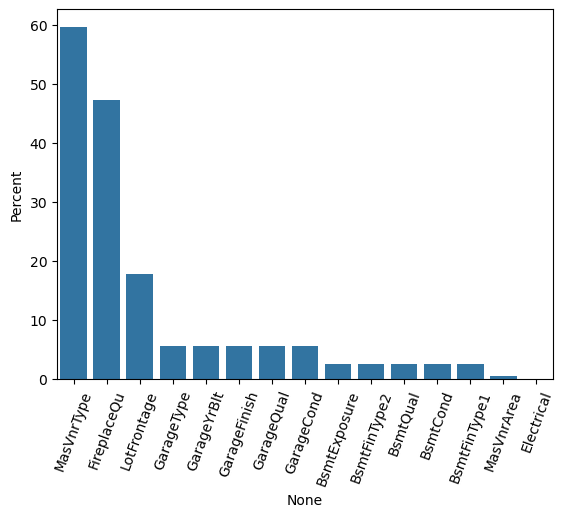

In [48]:
percent = 0
missings_bar_vizualisation(after_drops,percent)

### EDA

In [49]:
'''
Функция для визуализации hist plot ,boxplot,countplot и Scatter plot для всех признаков
data_frame - анализируемый датафрейм
cols - кол-во колонок для вывода(3 по умолчанию)
cell - целевая переменная используется для построения scatterplot

'''

def overall_viz(data_frame,cols,cell):

    heart_CAT = data_frame.columns.to_list()

#  Categorical Data

    b = cols  # number of columns
    a = math.ceil(len(heart_CAT)/b)*3  # number of rows
    c = 1  # initialize plot counter

    fig = plt.figure(figsize = (20,200))



    for i in heart_CAT:
        
        if data_frame[i].dtype in ['float64','int64']:
            
            plt.subplot(a, b, c)
            plt.xlabel(i)
            sns.boxplot(data = data_frame, x = i)
            c = c + 1
    
            plt.subplot(a, b, c)
            plt.xlabel(i)
            sns.histplot(data = data_frame, x = i)
            c = c + 1
            
            plt.subplot(a, b, c)
            plt.xlabel(i)
            sns.scatterplot(data=data_frame, x=cell, y=i)
            c = c + 1
        
        elif data_frame[i].dtype in ['object']:
            
            plt.subplot(a, b, c)
            plt.xlabel(i)
            sns.countplot(data = data_frame, x = i)
            c = c + 1
            
            plt.subplot(a, b, c)
            plt.xlabel(i)
            sns.histplot(data = data_frame, x = i)
            c = c + 1
            
            plt.subplot(a, b, c)
            plt.xlabel(i)
            sns.scatterplot(data=data_frame, x=cell, y=i)
            c = c + 1
        
        
#QQ Plot    
#    plt.subplot(a, b, c)
#    plt.xlabel(i)
#    pplot(data = after_drops_numeric,x = i,kind='qq')
#    c = c + 1

    fig.tight_layout(h_pad=2,w_pad=2)
    
    plt.show()

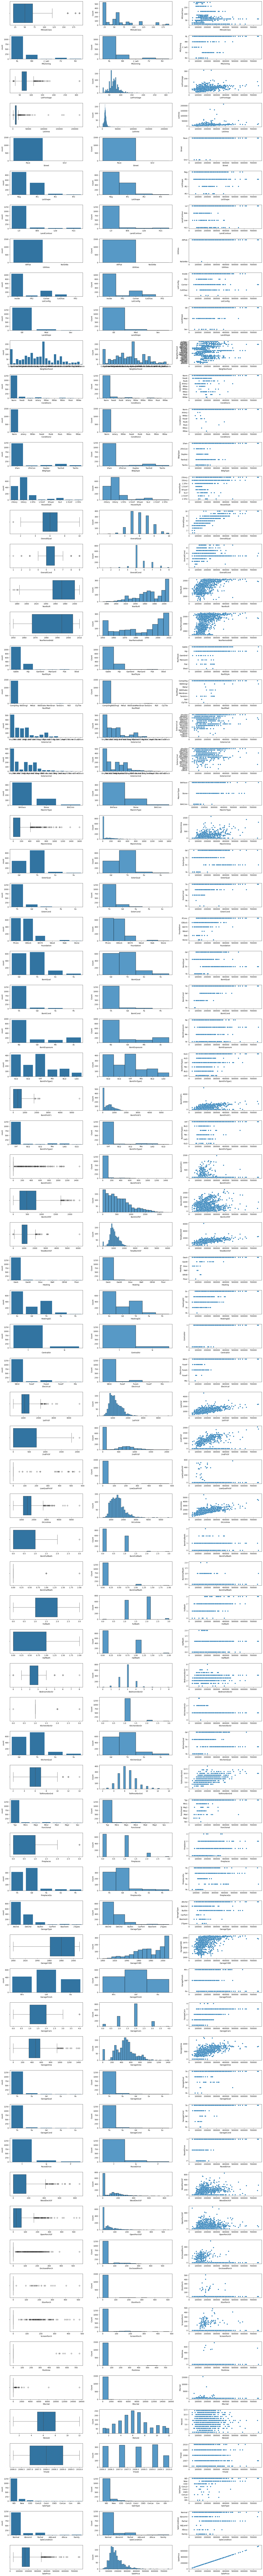

In [50]:
overall_viz(after_drops,3,"SalePrice")

In [ ]:
# Есть аномальные значения - выбросы, которые можно было бы и убрать но в рамках этой задачи пока не будем этого делать.

In [ ]:
# Так же можно было бы построить обычную регрессию для проверки влияния переменной на целевую

### Transform data

In [51]:
#Типы данных по оставшемся колонкам

after_drops.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [ ]:
# Сразу преобразуем все наши данные :заполним пропуски, декодируем категориальные переменные и нормализуем данные

In [52]:
#Уберем целевую переменную до всех преобразований

target = after_drops[['SalePrice']]

In [53]:
after_drops.drop(columns = ['SalePrice'],inplace=True)

In [54]:
after_drops.shape

(1460, 75)

#### Imputation missings

In [55]:
# Разделяем на числовые и категориальные данные

num_cols = after_drops.select_dtypes(include=['float64', 'int64']).columns.to_list()

cat_cols = after_drops.select_dtypes(include=['object']).columns.to_list()

##### Numeric variablse

In [56]:
# Сделаем Pipline

imputer_num = SimpleImputer(strategy='median').fit(after_drops[num_cols])  # Медианное для числовых
min_max_scaler = MinMaxScaler().fit(after_drops[num_cols])

numeric_transformer = Pipeline(steps=[
    ('imputer', imputer_num ),  # Заполнение пропусков
    ('scaler', min_max_scaler)  # Масштабирование
])

#Вернем преобразованный DataFrame 

after_drops[num_cols] = pd.DataFrame(numeric_transformer.transform(after_drops[num_cols]),columns = num_cols)

In [57]:
after_drops.head(5)

MSSubClass MSZoning  LotFrontage   LotArea Street LotShape LandContour  \
0    0.235294       RL     0.150685  0.033420   Pave      Reg         Lvl   
1    0.000000       RL     0.202055  0.038795   Pave      Reg         Lvl   
2    0.235294       RL     0.160959  0.046507   Pave      IR1         Lvl   
3    0.294118       RL     0.133562  0.038561   Pave      IR1         Lvl   
4    0.235294       RL     0.215753  0.060576   Pave      IR1         Lvl   

  Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
0    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
1    AllPub       FR2       Gtl      Veenker      Feedr       Norm     1Fam   
2    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
3    AllPub    Corner       Gtl      Crawfor       Norm       Norm     1Fam   
4    AllPub       FR2       Gtl      NoRidge       Norm       Norm     1Fam   

  HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle  \
0     2Story     0.666667        0.500   0.949275      0.883333     Gable   
1     1Story     0.555556        0.875   0.753623      0.433333     Gable   
2     2Story     0.666667        0.500   0.934783      0.866667     Gable   
3     2Story     0.666667        0.500   0.311594      0.333333     Gable   
4     2Story     0.777778        0.500   0.927536      0.833333     Gable   

  RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond  \
0  CompShg     VinylSd     VinylSd    BrkFace     0.12250        Gd        TA   
1  CompShg     MetalSd     MetalSd       None     0.00000        TA        TA   
2  CompShg     VinylSd     VinylSd    BrkFace     0.10125        Gd        TA   
3  CompShg     Wd Sdng     Wd Shng       None     0.00000        TA        TA   
4  CompShg     VinylSd     VinylSd    BrkFace     0.21875        Gd        TA   

  Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1  \
0      PConc       Gd       TA           No          GLQ    0.125089   
1     CBlock       Gd       TA           Gd          ALQ    0.173281   
2      PConc       Gd       TA           Mn          GLQ    0.086109   
3     BrkTil       TA       Gd           No          ALQ    0.038271   
4      PConc       Gd       TA           Av          GLQ    0.116052   

  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC  \
0          Unf         0.0   0.064212     0.140098    GasA        Ex   
1          Unf         0.0   0.121575     0.206547    GasA        Ex   
2          Unf         0.0   0.185788     0.150573    GasA        Ex   
3          Unf         0.0   0.231164     0.123732    GasA        Gd   
4          Unf         0.0   0.209760     0.187398    GasA        Ex   

  CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  \
0          Y      SBrkr  0.119780  0.413559           0.0   0.259231   
1          Y      SBrkr  0.212942  0.000000           0.0   0.174830   
2          Y      SBrkr  0.134465  0.419370           0.0   0.273549   
3          Y      SBrkr  0.143873  0.366102           0.0   0.260550   
4          Y      SBrkr  0.186095  0.509927           0.0   0.351168   

   BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0      0.333333           0.0  0.666667       0.5         0.375      0.333333   
1      0.000000           0.5  0.666667       0.0         0.375      0.333333   
2      0.333333           0.0  0.666667       0.5         0.375      0.333333   
3      0.333333           0.0  0.333333       0.0         0.375      0.333333   
4      0.333333           0.0  0.666667       0.5         0.500      0.333333   

  KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  \
0          Gd      0.500000        Typ    0.000000        None     Attchd   
1          TA      0.333333        Typ    0.333333          TA     Attchd   
2          Gd      0.333333        Typ    0.333333          TA     Attchd   
3          Gd      0.

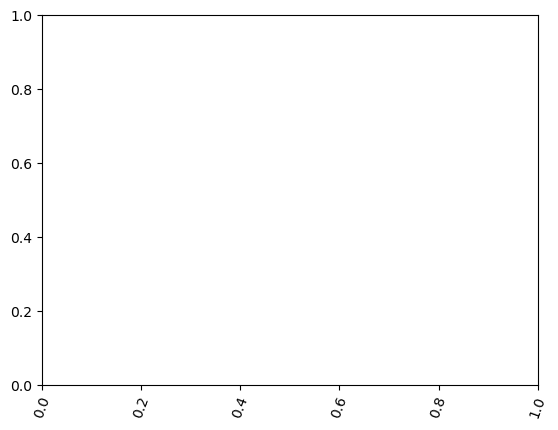

In [58]:
missings_bar_vizualisation(after_drops[num_cols],0)

In [59]:
#Сохраним наш пайплайн

with open('num_pipe.pkl', 'wb') as f:
    pickle.dump(numeric_transformer, f)

##### Categorical Variables

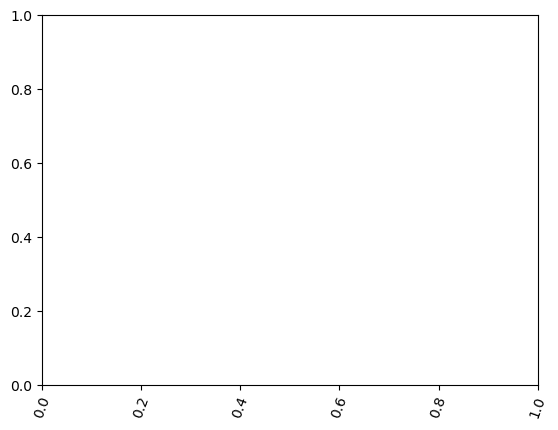

In [60]:
#Обучим Imputer для заполнения пропусков

cat_imputer = SimpleImputer(missing_values = pd.NA,strategy='most_frequent').fit(after_drops[cat_cols])  # Мода для категориальных

#Применим

after_drops[cat_cols] = pd.DataFrame(cat_imputer.transform(after_drops[cat_cols]),columns = cat_cols)

#Проверим что все работает

missings_bar_vizualisation(after_drops[cat_cols],0)

In [61]:
after_drops.head(2)

MSSubClass MSZoning  LotFrontage   LotArea Street LotShape LandContour  \
0    0.235294       RL     0.150685  0.033420   Pave      Reg         Lvl   
1    0.000000       RL     0.202055  0.038795   Pave      Reg         Lvl   

  Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
0    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
1    AllPub       FR2       Gtl      Veenker      Feedr       Norm     1Fam   

  HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle  \
0     2Story     0.666667        0.500   0.949275      0.883333     Gable   
1     1Story     0.555556        0.875   0.753623      0.433333     Gable   

  RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond  \
0  CompShg     VinylSd     VinylSd    BrkFace      0.1225        Gd        TA   
1  CompShg     MetalSd     MetalSd    BrkFace      0.0000        TA        TA   

  Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1  \
0      PConc       Gd       TA           No          GLQ    0.125089   
1     CBlock       Gd       TA           Gd          ALQ    0.173281   

  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC  \
0          Unf         0.0   0.064212     0.140098    GasA        Ex   
1          Unf         0.0   0.121575     0.206547    GasA        Ex   

  CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  \
0          Y      SBrkr  0.119780  0.413559           0.0   0.259231   
1          Y      SBrkr  0.212942  0.000000           0.0   0.174830   

   BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0      0.333333           0.0  0.666667       0.5         0.375      0.333333   
1      0.000000           0.5  0.666667       0.0         0.375      0.333333   

  KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  \
0          Gd      0.500000        Typ    0.000000          Gd     Attchd   
1          TA      0.333333        Typ    0.333333          TA     Attchd   

   GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond  \
0     0.936364          RFn         0.5    0.386460         TA         TA   
1     0.690909          RFn         0.5    0.324401         TA         TA   

  PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0          Y    0.000000     0.111517            0.0        0.0          0.0   
1          Y    0.347725     0.000000            0.0        0.0          0.0   

   PoolArea  MiscVal    MoSold  YrSold SaleType SaleCondition  
0       0.0      0.0  0.090909    0.50       WD        Normal  
1       0.0      0.0  0.363636    0.25       WD        Normal

In [62]:
#Сохраним наш Imputer

with open('cat_imputer.pkl', 'wb') as f:
    pickle.dump(cat_imputer, f)

In [25]:
'''
#Преобразуем категориальные переменные в числовые

def label_encode(X):
    return X.apply(lambda col: LabelEncoder().fit_transform(col))
  
# Оборачиваем LabelEncoder в FunctionTransformer

#label_encoder_transformer = FunctionTransformer(label_encode, validate=False).fit(after_drops[cat_cols])

with open('label_encoder_transformer_2.pkl', 'wb') as f:
    dill.dump(label_encoder_transformer, f)
'''

In [63]:
#Воспользуемся OrdinalEncoder

ordinal_encoder = OrdinalEncoder().fit(after_drops[cat_cols])


In [64]:
after_drops[cat_cols] = pd.DataFrame(ordinal_encoder.transform(after_drops[cat_cols]), columns=cat_cols)

In [65]:
after_drops.head(5)

MSSubClass  MSZoning  LotFrontage   LotArea  Street  LotShape  LandContour  \
0    0.235294       3.0     0.150685  0.033420     1.0       3.0          3.0   
1    0.000000       3.0     0.202055  0.038795     1.0       3.0          3.0   
2    0.235294       3.0     0.160959  0.046507     1.0       0.0          3.0   
3    0.294118       3.0     0.133562  0.038561     1.0       0.0          3.0   
4    0.235294       3.0     0.215753  0.060576     1.0       0.0          3.0   

   Utilities  LotConfig  LandSlope  Neighborhood  Condition1  Condition2  \
0        0.0        4.0        0.0           5.0         2.0         2.0   
1        0.0        2.0        0.0          24.0         1.0         2.0   
2        0.0        4.0        0.0           5.0         2.0         2.0   
3        0.0        0.0        0.0           6.0         2.0         2.0   
4        0.0        2.0        0.0          15.0         2.0         2.0   

   BldgType  HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0       0.0         5.0     0.666667        0.500   0.949275      0.883333   
1       0.0         2.0     0.555556        0.875   0.753623      0.433333   
2       0.0         5.0     0.666667        0.500   0.934783      0.866667   
3       0.0         5.0     0.666667        0.500   0.311594      0.333333   
4       0.0         5.0     0.777778        0.500   0.927536      0.833333   

   RoofStyle  RoofMatl  Exterior1st  Exterior2nd  MasVnrType  MasVnrArea  \
0        1.0       1.0         12.0         13.0         1.0     0.12250   
1        1.0       1.0          8.0          8.0         1.0     0.00000   
2        1.0       1.0         12.0         13.0         1.0     0.10125   
3        1.0       1.0         13.0         15.0         1.0     0.00000   
4        1.0       1.0         12.0         13.0         1.0     0.21875   

   ExterQual  ExterCond  Foundation  BsmtQual  BsmtCond  BsmtExposure  \
0        2.0        4.0         2.0       2.0       3.0           3.0   
1        3.0        4.0         1.0       2.0       3.0           1.0   
2        2.0        4.0         2.0       2.0       3.0           2.0   
3        3.0        4.0         0.0       3.0       1.0           3.0   
4        2.0        4.0         2.0       2.0       3.0           0.0   

   BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0           2.0    0.125089           5.0         0.0   0.064212     0.140098   
1           0.0    0.173281           5.0         0.0   0.121575     0.206547   
2           2.0    0.086109           5.0         0.0   0.185788     0.150573   
3           0.0    0.038271           5.0         0.0   0.231164     0.123732   
4           2.0    0.116052           5.0         0.0   0.209760     0.187398   

   Heating  HeatingQC  CentralAir  Electrical  1stFlrSF  2ndFlrSF  \
0      1.0        0.0         1.0         4.0  0.119780  0.413559   
1      1.0        0.0         1.0         4.0  0.212942  0.000000   
2      1.0        0.0         1.0         4.0  0.134465  0.419370   
3      1.0        2.0         1.0         4.0  0.143873  0.366102   
4      1.0        0.0         1.0         4.0  0.186095  0.509927   

   LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  \
0           0.0   0.259231      0.333333           0.0  0.666667       0.5   
1           0.0   0.174830      0.000000           0.5  0.666667       0.0   
2           0.0   0.273549      0.333333           0.0  0.666667       0.5   
3           0.0   0.260550      0.333333           0.0  0.333333       0.0   
4           0.0   0.351168      0.333333           0.0  0.666667       0.5   

   BedroomAbvGr  KitchenAbvGr  KitchenQual  TotRmsAbvGrd  Functional  \
0         0.375      0.333333          2.0      0.500000         6.0   
1         0.375      0.333333          3.0      0.333333         6.0   
2         0.375      0.333333          2.0      0.333333         6.0   
3         0.375      0.333333      

In [66]:
#Сохраним наш label_encoder_transformer

with open('ordinal_encoder.pkl', 'wb') as f:
    pickle.dump(ordinal_encoder, f)

In [67]:
after_drops.shape

(1460, 75)

#### Тут возможен блок по выбору фич для модели

### Model train and selection

In [68]:
#Разделим набор данных и целевую переменную

X_train = after_drops
Y_train = target


In [69]:
# Возьмем сразу несколько моделей и сделаем поиск по сетке
#Параметры по моделям Регрессоров(Надо засунуть в yaml)

catboost_params = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [3, 6,10]
         }

lasso_params = {
    'alpha':[0.01,0.1,0,10,100,200,300,500]
        }

ridge_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}

xgb_params ={"learning_rate": (0.05, 0.10, 0.15),
                        "max_depth": [ 3, 4, 5, 6, 8],
                        "min_child_weight": [ 1, 3, 5, 7],
                        "gamma":[ 0.0, 0.1, 0.2],
                        "colsample_bytree":[ 0.3, 0.4]
            }

DecisionTreeRegressor_params = [
    {'max_depth': [3, 5, 10], 
     'max_features': [3, 4, 5]},
    {'random_state': [0, 1, 2, 3, 4], 
     'min_samples_split': [2, 3, 4]}    
]

ElasticNet_params = [
        {'alpha': [.0004, .0005], 'l1_ratio': [.5, .8, 1]}
]

#Словарь модель:параметры

models_dict = {'models':
               [CatBoostRegressor(),
                Lasso(),
                XGBRegressor(),
                Ridge(),
                DecisionTreeRegressor(),
                ElasticNet()
               ],
               
               'params':[catboost_params,
                         lasso_params,
                         xgb_params,
                         ridge_params,
                         DecisionTreeRegressor_params,
                         ElasticNet_params
                        ]
              }

error = 'r2'


In [70]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

####Блок по моделям

def models_cyckle(X_train,Y_train,folds,error):

    models_report = pd.DataFrame()
    
    for i in range(len(models_dict['models'])):
        
        
          
        grid_search = GridSearchCV(models_dict['models'][i], param_grid=models_dict['params'][i], cv=folds, scoring=error, n_jobs=-1)
        grid_search.fit(X_train, Y_train)
    
        best_model = pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score').head(1)
        best_model['model_name'] = str(models_dict['models'][i])
        models_report = pd.concat([models_report,best_model])
    
    return models_report

In [71]:
report = models_cyckle(X_train,Y_train,folds,error)

0:	learn: 79508.3781190	total: 49.8ms	remaining: 9.9s
1:	learn: 79045.4554103	total: 50.4ms	remaining: 4.99s
2:	learn: 78615.5497024	total: 52.6ms	remaining: 3.46s
3:	learn: 78168.8277519	total: 59.4ms	remaining: 2.91s
4:	learn: 77713.6212474	total: 60.2ms	remaining: 2.35s
5:	learn: 77252.9813743	total: 70ms	remaining: 2.26s
6:	learn: 76837.3729353	total: 70.6ms	remaining: 1.95s
7:	learn: 76389.2934344	total: 71.4ms	remaining: 1.71s
8:	learn: 75976.8474011	total: 72.1ms	remaining: 1.53s
9:	learn: 75540.8500043	total: 72.8ms	remaining: 1.38s
10:	learn: 75101.7063907	total: 73.5ms	remaining: 1.26s
11:	learn: 74673.9695659	total: 74.2ms	remaining: 1.16s
12:	learn: 74246.5308640	total: 74.9ms	remaining: 1.08s
13:	learn: 73809.9755722	total: 75.7ms	remaining: 1s
14:	learn: 73377.4192622	total: 76.4ms	remaining: 942ms
15:	learn: 72995.1789190	total: 77.1ms	remaining: 886ms
16:	learn: 72624.2450364	total: 77.7ms	remaining: 837ms
17:	learn: 72232.3877840	total: 78.6ms	remaining: 795ms
18:	lear

/home/aleksey/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/aleksey/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/aleksey/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/aleksey/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/aleksey/anacon

In [72]:
report.loc[:,:'model_name'].sort_values(by='mean_test_score',ascending = False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_depth  \
269       0.161078      0.008869         0.017443        0.001176         NaN   
7         2.831797      0.465069         0.017199        0.022350           6   
5         0.010827      0.001634         0.003643        0.000181         NaN   
3         0.022803      0.010252         0.004252        0.000836         NaN   
9         0.029586      0.003563         0.002912        0.000643         NaN   
0         0.036338      0.002100         0.008461        0.000038         NaN   

    param_iterations param_learning_rate  \
269              NaN                 0.1   
7                200                 0.1   
5                NaN                 NaN   
3                NaN                 NaN   
9                NaN                 NaN   
0                NaN                 NaN   

                                                                                                   params  \
269  {'colsample_bytree': 0.4, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3}   
7                                                   {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}   
5                                                                                          {'alpha': 200}   
3                                                                      {'alpha': 0.0005, 'l1_ratio': 0.5}   
9                                                             {'min_samples_split': 2, 'random_state': 0}   
0                                                                                          {'alpha': 200}   

     split0_test_score  split1_test_score  split2_test_score  \
269           0.904542           0.853790           0.903866   
7             0.910878           0.870658           0.862964   
5             0.849592           0.819911           0.733446   
3             0.858626           0.823897           0.685631   
9             0.791990           0.764932           0.729319   
0             0.720131           0.736387           0.677619   

     split3_test_score  split4_test_score  mean_test_score  std_test_score  \
269           0.856034           0.884650         0.880576        0.022150   
7             0.858859           0.898041         0.880280        0.020508   
5             0.822213           0.829278         0.810888        0.040108   
3             0.809517           0.842528         0.804040        0.061491   
9             0.782595           0.771115         0.767990        0.021466   
0             0.756952           0.706508         0.719520        0.026874   

     rank_test_score  \
269                1   
7                  1   
5                  1   
3                  1   
9                  1   
0                  1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               model_name  
269  XGBRegressor(base_score=None, booster=None, callbacks=None,\n             colsample_bylevel=None, colsample_bynode=None,\n             colsample_bytree=None, device=None, early_stopping_rounds=None,\n             enable_categorical=False, eval_metric=None, feature_types=None,\n             gamma=None, grow_policy=None, importance_type=None,\n             interaction_constraints=None, learning_rate=None, max_bin=None,\n        

In [ ]:
#Получаем что лучше всего с задачей справился XGBRegressor

In [73]:
#Выбираем XGBRegressor с такими параметрами

#{'colsample_bytree': 0.3, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1}

xgb_params ={"learning_rate": 0.1,
                        "max_depth": 4,
                        "min_child_weight":1,
                        "gamma":0.1,
                        "colsample_bytree":0.3
            }


In [74]:
#Передаем в модель наши параметры

xgb_model = XGBRegressor(**xgb_params).fit(X_train, Y_train)


In [75]:
# Сохраним наши модели

with open("XGBRegressor.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

#### Вложение - Тут у нас хранятся различные промежуточные шаги которые возникали в процессе работы

##### Пошаговая проверка того как работает Imputer с числовыми переменными

In [ ]:
'''

# Пошаговая проверка того как работает Imputer с числовыми переменными

# Разделяем на числовые и категориальные данные

num_cols = after_drops.select_dtypes(include=['float64', 'int64']).columns.to_list()

cat_cols = after_drops.select_dtypes(include=['object']).columns.to_list()

#Выведем данные для последующей проверки

after_drops[num_cols].median()

#Возьмем данные с пустыми значениями

test = after_drops[after_drops[num_cols].isnull().any(axis=1)]
test.head(5)

#Обучим

imputer_num = SimpleImputer(strategy='median').fit(after_drops[num_cols])  # Медианное для числовых

# Применим Imputer

after_drops[num_cols] = imputer_num.transform(after_drops[num_cols])

# Проверим missings

missings_bar_vizualisation(after_drops[num_cols],0)

# Проверим чем он заполнил

imputer_num.statistics_

#Подставим в нашу таблицу индексы в которых были пропуски и посмотрим как все заполнилось

after_drops[num_cols][after_drops[num_cols].index.isin(test.index.to_list())]

# Нормализируем числовые переменные

# Создание MinMaxScaler

min_max_scaler = MinMaxScaler().fit(after_drops[num_cols])

# Применение нормализации

after_drops[num_cols] = min_max_scaler.transform(after_drops[num_cols])

# Смотрим что все заполнилось

after_drops[num_cols].head(5)

'''

##### Простое ручное заполнение пропусков через цикл

In [ ]:

'''
#Простое ручное заполнение пропусков через цикл (данный метод не очень одобен для последующего использования модели на проде)

#Выведем данные для последующей проверки

after_drops.select_dtypes(include = ['float64','int64']).median()

#Возьмем данные с пустыми значениями

test = after_drops[after_drops.select_dtypes(include = ['float64','int64']).isnull().any(axis=1)]
test.head(10)

#Заполним пропуски по всем переменным. Для числовых ставим median() для категориальных "None"

unique_types = after_drops.dtypes.unique()

#Для простоты заполним медианным значением

for typ in unique_types:
    
    if typ == 'object':
        
        object_columns = after_drops.select_dtypes(include = ['object']).columns.to_list()
        after_drops[object_columns] = after_drops[object_columns].fillna('None')
    
    elif typ in ['float64','int64']:
        
        int_columns = after_drops.select_dtypes(include = ['float64','int64']).columns.to_list()
        after_drops[int_columns] = after_drops[int_columns].fillna(after_drops[int_columns].median())

# Проверим как все заполнилось

after_drops[after_drops.index.isin(test.index.to_list())]

'''


##### Преобразование категориальных признаков.(ручное)

In [ ]:

'''
Преобразование категориальных признаков.
В дальнейшем мы будем использовать Catboost, который может принимать категориальные признаки и так, 
но помимо catboost будем использовать и другие модели которым нужно преобразование ,поэтому оставим этот код тут.

Так же преобразование категориальных признаков нужно делать аккуратно 

#Lable encoding

cols = df_imputed.select_dtypes(include = ['object']).columns.to_list()

#transform_df = pd.DataFrame()

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df_imputed[c].values)) 
    df_imputed[c] = lbl.transform(list(df_imputed[c].values))

#Проверим что все преобразовалось

df_imputed[cat_cols]

Необязательное действие

#Создадим словарь для последующего декодирования
    
    keys = lbl.classes_
    values = lbl.transform(lbl.classes_)
    transform = pd.DataFrame(zip(keys, values),columns = ['name','transform_value'])
    transform['feature_name'] = c
    transform_df = pd.concat([transform,transform_df])

#Само декодирование

obj_col = test_df_2.select_dtypes('object').columns.to_list()
for i in obj_col:
    test_df_2[i] = test_df_2[i].map(transform_df[['name','transform_value']][transform_df['feature_name'] == i].set_index('name').to_dict()['transform_value'])

'''

##### Всякое

In [ ]:
'''
# Создадим пайплайн который у нас получился на данный момент по всем преобразованиям

# Определяем числовые и категориальные столбцы

num_cols = after_drops.select_dtypes(include = ['float64','int64']).columns
cat_cols = after_drops.select_dtypes(include = ['object']).columns

# Перевод категориальных признаков в числовые

def label_encode(X):
    return X.apply(lambda col: LabelEncoder().fit_transform(col))

# Оборачиваем LabelEncoder в FunctionTransformer

label_encoder_transformer = FunctionTransformer(label_encode, validate=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_cols),  # Импьютер для числовых данных
        ('cat', SimpleImputer(missing_values = pd.NA,strategy='most_frequent'), cat_cols)   # Импьютер для категориальных данных
       # ('stand_num',MinMaxScaler(),num_cols) # Стандартизация числовых признаков
       #('cat_encoding',label_encoder_transformer,cat_cols) # Перевод категориальных признаков в числовые
    ])

preprocessor.fit(after_drops)
X_transformed = preprocessor.transform(after_drops)

'''

'''
Тут происходит затык

#Обучим Imputer для заполнения пропусков

cat_imputer = SimpleImputer(missing_values = pd.NA,strategy='most_frequent').fit(after_drops[cat_cols])  # Мода для категориальных

#Применим

cat_imputered = pd.DataFrame(cat_imputer.transform(after_drops[cat_cols]),columns = cat_cols)

#Проверим что все работает

missings_bar_vizualisation(cat_imputered,0)

#Преобразуем категориальные переменные в числовые

def label_encode(X):
    return X.apply(lambda col: LabelEncoder().fit_transform(col))
  
# Оборачиваем LabelEncoder в FunctionTransformer

label_encoder_transformer = FunctionTransformer(label_encode, validate=False).fit(cat_imputered)

#Применяем и смотрим результат

cat_transformed = label_encoder_transformer.transform(cat_imputered)

#Делаем пайплайн для категориальных переменных

categorical_transformer = Pipeline(steps=[
    ('imputer', cat_imputer ),  # Заполнение пропусков
    ('cat_encoder', label_encoder_transformer)  # Преобразование в числовые значения
])

#Проверим работаспособность

#cat_transformed_test = pd.DataFrame(categorical_transformer.transform(after_drops[cat_cols]),columns = cat_cols)

#Объединяем данные

fin = num_transformed.join(cat_transformed)

'''
